# AMLB Visualizations
This notebook contains code to generate critical difference diagrams (Figure 2) from the paper "AMLB: an AutoML Benchmark" by Gijsbers et al. (2022). As input, it assumes "cleaned logs" which are available at `http://openml-test.win.tue.nl/amlb/*_cleaned.csv` and the `CleanResults` notebook shows how they are constructed from the raw results. 

The `orange` dependency for CD plots can be problematic with (some?) Windows setups, but it is possible to install only a few of `orange`'s dependencies to make it work. It might help first installing the latest version of `Orange3` and then downgrading with `python -m pip install "Orange3==3.30.0" --no-deps`.

In [1]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import Orange

from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, is_old

In [2]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures" / "CD"
FIGURE_DIRECTORY.mkdir(parents=True, exist_ok=True)

In [3]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})
results = results[~results["framework"].isin(["NaiveAutoML", "autosklearn2"])]
results["framework"] = results["framework"].apply(get_print_friendly_name)

# CD Plots
Figure 2 in the paper.

In [4]:
def plot_cd(results, filename=None):
    ranks = calculate_ranks(results)
    n_tasks = results["task"].nunique()
    critical_difference = Orange.evaluation.compute_CD(ranks.values(), n_tasks)
    Orange.evaluation.graph_ranks(
        ranks.values(),
        list(ranks),
        cd=critical_difference,
        width=6,
        textspace=1.5,
        filename=filename
    )
    plt.title(filename.name)

generating cd-multiclass-classification-1h8c_gp3-constantpredictor.pdf
generating cd-binary-classification-1h8c_gp3-constantpredictor.pdf
generating cd-regression-1h8c_gp3-constantpredictor.pdf
generating cd-multiclass-classification-4h8c_gp3-constantpredictor.pdf
generating cd-binary-classification-4h8c_gp3-constantpredictor.pdf
generating cd-regression-4h8c_gp3-constantpredictor.pdf


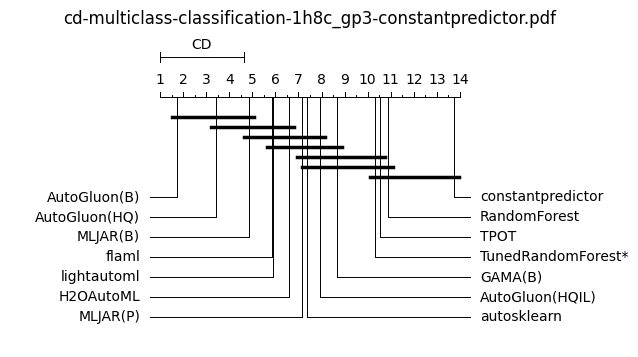

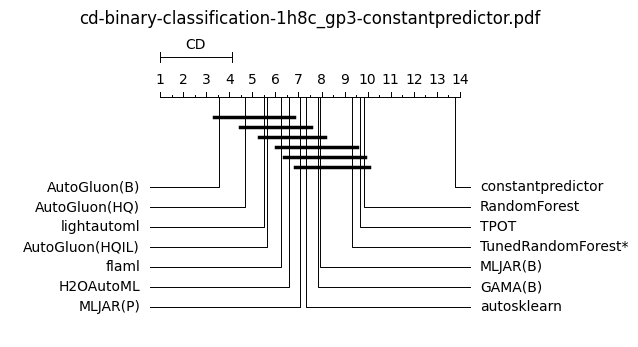

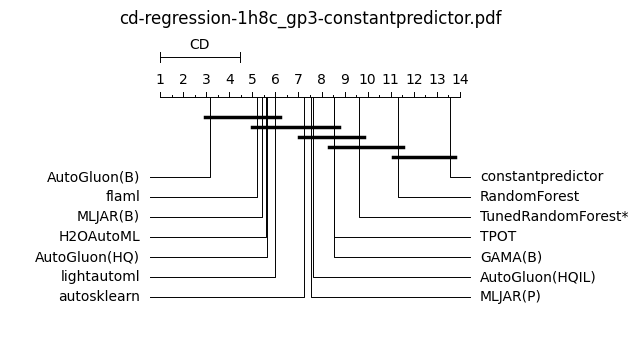

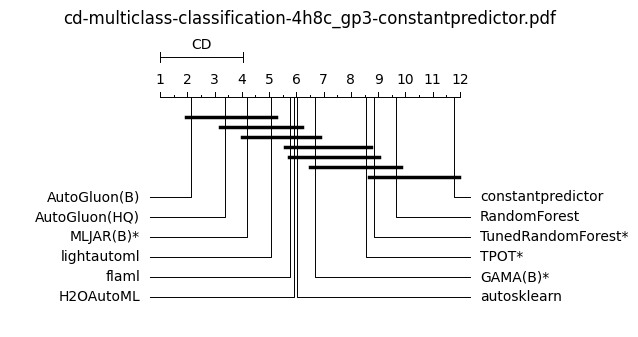

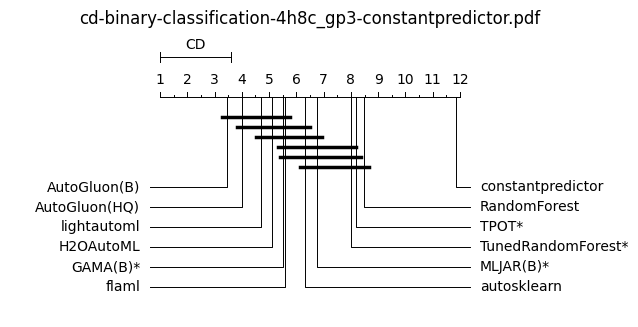

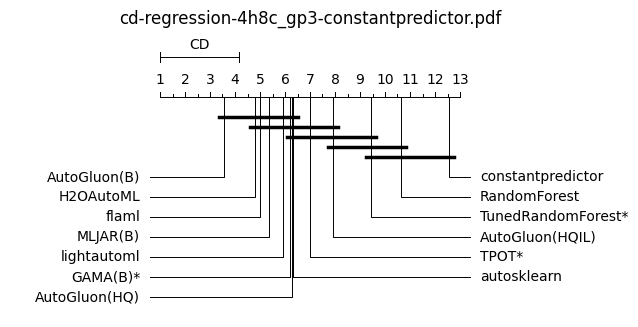

In [5]:
for constraint, metric in itertools.product(results.constraint.unique(), results.metric.unique()):    
    data = results[(results["constraint"] == constraint) & (results["metric"] == metric)].copy()
    data["framework"] = data["framework"].apply(lambda name: f'{name}*' if is_old(name, constraint, metric) else name)
    ttype = {"neg_rmse": "regression", "auc": "binary classification", "neg_logloss": "multiclass classification"}[metric]
    # We exclude autosklearn2 because the metadataset overlaps with the benchmark
    data = data[data["framework"] != "autosklearn2"]
    data = impute_missing_results(data, with_results_from="constantpredictor")
    
    filename = f"cd-{ttype.replace(' ','-')}-{constraint}-constantpredictor.pdf"
    print("generating", filename)
    plot_cd(data, filename=FIGURE_DIRECTORY / filename)

generating cd-all-1h8c_gp3-constantpredictor.pdf
generating cd-all-4h8c_gp3-constantpredictor.pdf


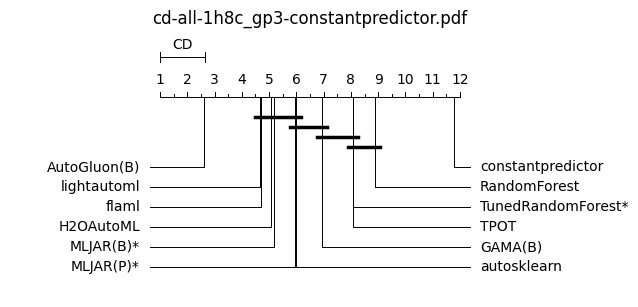

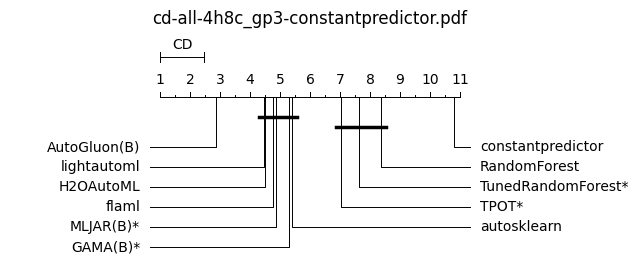

In [6]:
for constraint in ["1h8c_gp3", "4h8c_gp3"]:
    data = results[(results["constraint"] == constraint)].copy()
    data["framework"] = data.apply(
        lambda row: f'{row["framework"]}*' if is_old(row["framework"], constraint, row["metric"]) or "MLJAR" in row["framework"] else row["framework"], 
        axis=1
    )
    ttype = "all"
    # We exclude autosklearn2 because the metadataset overlaps with the benchmark
    data = data[~data["framework"].isin(["autosklearn2", "AutoGluon(HQ)", "AutoGluon(HQIL)"])]
    data = impute_missing_results(data, with_results_from="constantpredictor")
    
    filename = f"cd-{ttype}-{constraint}-constantpredictor.pdf"
    print("generating", filename)
    plot_cd(data, filename=FIGURE_DIRECTORY / filename)